In [21]:
import glob
import json

import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer, util

import scorer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

C:\Users\mitre\anaconda3\envs\tuw-nlp_and_ie\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mitre\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fall

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mitre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mitre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
DATA_PATH = "../data"
PARSED_PATH = f"{DATA_PATH}/raw/parsed_sections"
ABSTRACT_PATH = f"{DATA_PATH}/raw/abstracts"

In [5]:
content_files = glob.glob(f"{PARSED_PATH}/*.json")
abstract_files = glob.glob(f"{ABSTRACT_PATH}/*.txt")

abstract_content_mapping = {}

for file in content_files:
    paper_id = file.split("\\")[1].replace(".json", "")
    with open(file, "r", encoding="utf-8") as json_file:
        #file_contents.append(json.load(json_file))
        abstract_content_mapping[paper_id] = {}
        abstract_content_mapping[paper_id]["content"] = json.load(json_file)

for file in abstract_files:
    paper_id = file.split("\\")[1].replace(".txt", "")
    with open(file, "r", encoding="utf-8") as txt_file:
        try:
            abstract_content_mapping[paper_id]["abstract"] = ' '.join(txt_file.readlines())
            print(f"Read {file}")
        except Exception as e:
            pass
        
abstract_content_mapping

Read ../data/raw/abstracts\2510.25775v1.txt
Read ../data/raw/abstracts\2510.25813v1.txt
Read ../data/raw/abstracts\2510.25820v1.txt
Read ../data/raw/abstracts\2510.25860v1.txt
Read ../data/raw/abstracts\2510.25883v1.txt
Read ../data/raw/abstracts\2510.25884v1.txt
Read ../data/raw/abstracts\2510.25908v1.txt
Read ../data/raw/abstracts\2510.25914v1.txt
Read ../data/raw/abstracts\2510.25933v1.txt
Read ../data/raw/abstracts\2510.25951v1.txt
Read ../data/raw/abstracts\2510.25997v1.txt
Read ../data/raw/abstracts\2510.26012v1.txt
Read ../data/raw/abstracts\2510.26023v1.txt
Read ../data/raw/abstracts\2510.26094v1.txt
Read ../data/raw/abstracts\2510.26098v1.txt
Read ../data/raw/abstracts\2510.26136v1.txt
Read ../data/raw/abstracts\2510.26143v1.txt
Read ../data/raw/abstracts\2510.26144v1.txt
Read ../data/raw/abstracts\2510.26238v1.txt
Read ../data/raw/abstracts\2510.26242v1.txt
Read ../data/raw/abstracts\2510.26270v1.txt
Read ../data/raw/abstracts\2510.26309v1.txt
Read ../data/raw/abstracts\2510.

{'2510.25775v1': {'content': [{'title': '1 Introduction',
    'paragraphs': 'Evaluating a chess position is a complex endeavor that combines long-term strategic foresight with immediate tactical precision. Contemporary chess engines summarize their assessments into a single scalar metric, typically expressed in centipawns, approximating the material advantage. This evaluation is indispensable for decision-making and training, yet it remains opaque: it does not reveal which specific positional elements underlie the overall judgment [ 1 ] . This lack of interpretability poses challenges for human players who seek strategic clarity, as well as for researchers striving to understand the internal logic of modern engines [ 2 ] .\nIn contrast, the field of explainable AI (XAI) in machine learning has developed a rich array of methods for interpreting model outputs in classification and regression tasks [ 3 ] . Approaches such as feature attribution [ 4 ] , saliency maps, and Shapley value dec

In [6]:
def get_lead_N(content: dict, n: int) -> str:
    sentences = sent_tokenize(content[0]["paragraphs"])
    return ' '.join([s.strip() for s in sentences[:n]])

def get_lead_N_by_section(content: dict, n: int) -> str:
    lead_sentences = []
    for section in content:
        section_sentences = sent_tokenize(section["paragraphs"])
        lead_sentences.append(' '.join([s.strip() for s in section_sentences[:n]]))
    return ' '.join(lead_sentences)

In [14]:
scoring_results = []

for paper_id, mapping in abstract_content_mapping.items():
    lead_n_summary = get_lead_N(content=mapping["content"], n=5)
    lead_n_summary
    mapping["LEAD_N"] = lead_n_summary

    lead_n_by_section_summary = get_lead_N_by_section(content=mapping["content"], n=2)
    lead_n_by_section_summary
    mapping["LEAD_N_BY_SECTION"] = lead_n_by_section_summary

    # LEAD N
    rouge_scores_lead_n = scorer.get_rouge_scores(mapping["abstract"], mapping["LEAD_N"])
    #print(rouge_scores_lead_n["rouge1"].fmeasure, rouge_scores_lead_n["rouge2"].fmeasure, rouge_scores_lead_n["rougeL"].fmeasure)

    cosine_score_lead_n = scorer.get_embedding_cosine_similarity_score(model=model, abstract=mapping["abstract"], summary=mapping["LEAD_N"])
    #print(cosine_score_lead_n)

    scoring_results.append(
        {
            "paper_id": paper_id, 
            "method": "LEAD_N",
            "rouge1": rouge_scores_lead_n["rouge1"].fmeasure, 
            "rouge2": rouge_scores_lead_n["rouge2"].fmeasure, 
            "rougeL": rouge_scores_lead_n["rougeL"].fmeasure,
            "cosine_similarity": cosine_score_lead_n
        }
    )
    
    # LEAD N BY SECTION
    rouge_scores_lead_n_by_section = scorer.get_rouge_scores(mapping["abstract"], mapping["LEAD_N_BY_SECTION"])
    #print(rouge_scores_lead_n_by_section["rouge1"].fmeasure, rouge_scores_lead_n_by_section["rouge2"].fmeasure, rouge_scores_lead_n_by_section["rougeL"].fmeasure)

    cosine_score_lead_n_by_section = scorer.get_embedding_cosine_similarity_score(model=model, abstract=mapping["abstract"], summary=mapping["LEAD_N_BY_SECTION"])
    #print(cosine_score_lead_n_by_section)
    
    scoring_results.append(
        {
            "paper_id": paper_id, 
            "method": "LEAD_N_BY_SECTION",
            "rouge1": rouge_scores_lead_n_by_section["rouge1"].fmeasure, 
            "rouge2": rouge_scores_lead_n_by_section["rouge2"].fmeasure, 
            "rougeL": rouge_scores_lead_n_by_section["rougeL"].fmeasure,
            "cosine_similarity": cosine_score_lead_n_by_section
        }
    )

In [24]:
df_results

paper_id             method    rouge1    rouge2    rougeL  \
0    2510.25775v1             LEAD_N  0.412451  0.062745  0.171206   
1    2510.25775v1  LEAD_N_BY_SECTION  0.401937  0.111922  0.164649   
2    2510.25813v1             LEAD_N  0.380952  0.028846  0.171429   
3    2510.25813v1  LEAD_N_BY_SECTION  0.325275  0.101545  0.175824   
4    2510.25820v1             LEAD_N  0.369128  0.067568  0.187919   
..            ...                ...       ...       ...       ...   
111  2510.26788v1  LEAD_N_BY_SECTION  0.309942  0.085044  0.154971   
112  2510.26790v1             LEAD_N  0.245614  0.028269  0.119298   
113  2510.26790v1  LEAD_N_BY_SECTION  0.342282  0.101010  0.167785   
114  2510.26802v1             LEAD_N  0.331361  0.071429  0.153846   
115  2510.26802v1  LEAD_N_BY_SECTION  0.344398  0.066667  0.149378   

     cosine_similarity  
0             0.773316  
1             0.762034  
2             0.733838  
3             0.735509  
4             0.685825  
..                 ...  
111           0.696119  
112           0.715151  
113           0.844416  
114           0.623251  
115           0.789586  

[116 rows x 6 columns]

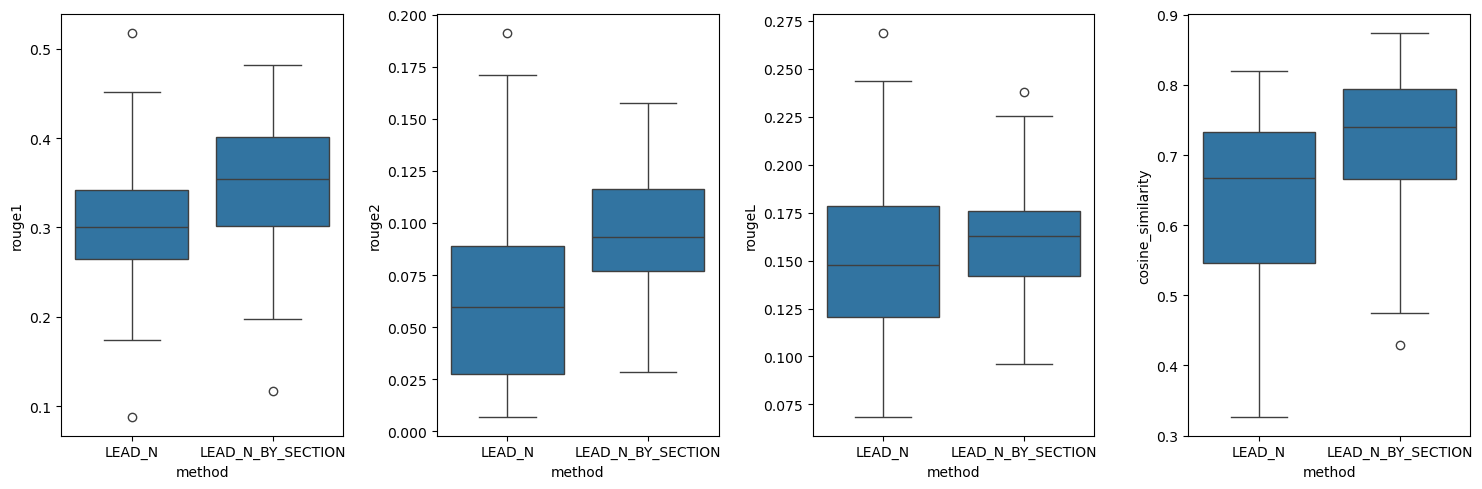

In [31]:
df_results = pd.DataFrame(scoring_results)
df_results

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
sns.boxplot(data=df_results, x="method", y="rouge1", ax=ax[0])
sns.boxplot(data=df_results, x="method", y="rouge2", ax=ax[1])
sns.boxplot(data=df_results, x="method", y="rougeL", ax=ax[2])
sns.boxplot(data=df_results, x="method", y="cosine_similarity", ax=ax[3])
plt.tight_layout()